# Question

Defining an "adopted user" as a user who has logged into the product on three separate
days in at least one sevenday
period , identify which factors predict future user
adoption .

## Approach

- Load Required Data into pandas dataframe
- Data Cleaning/Wrangling
- Create "Adopted" coloumn 1 if adopted else 0 , based on above defination.
- Correlation Analysis
- Feature importance analysis (using ensamble - random forest)
- Principal Component analysis
- Anlysis Report

In [1]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
users_data_file = "takehome_users.csv"
users_enagement_data_file = "takehome_user_engagement.csv"

users_df = pd.read_csv(users_data_file,encoding='ANSI')
users_enagement_df = pd.read_csv(users_enagement_data_file)

In [3]:
users_df.last_session_creation_time = pd.to_datetime(users_df.last_session_creation_time, errors='coerce')
users_df.creation_time = pd.to_datetime(users_df.creation_time, errors='coerce')
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.398138810,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1970-01-01 00:00:01.363734892,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.369210168,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.358849660,0,0,193,5240.0


In [4]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB


In [5]:
# Handle null values last_session_creation_time , invited_by_user_id
users_df.last_session_creation_time.fillna(0,inplace=True)
users_df.invited_by_user_id.fillna("0",inplace=True)
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  12000 non-null  object        
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          12000 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 937.6+ KB


In [6]:
print(users_df.describe())

print("max creation_time : {1}", max(users_df.creation_time))
print("min creation_time : {1}", min(users_df.creation_time))

         object_id  opted_in_to_mailing_list  enabled_for_marketing_drip  \
count  12000.00000              12000.000000                12000.000000   
mean    6000.50000                  0.249500                    0.149333   
std     3464.24595                  0.432742                    0.356432   
min        1.00000                  0.000000                    0.000000   
25%     3000.75000                  0.000000                    0.000000   
50%     6000.50000                  0.000000                    0.000000   
75%     9000.25000                  0.000000                    0.000000   
max    12000.00000                  1.000000                    1.000000   

             org_id  
count  12000.000000  
mean     141.884583  
std      124.056723  
min        0.000000  
25%       29.000000  
50%      108.000000  
75%      238.250000  
max      416.000000  
max creation_time : {1} 2014-05-30 23:59:19
min creation_time : {1} 2012-05-31 00:43:27


In [7]:
users_enagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [8]:
users_enagement_df['time_stamp'] = pd.to_datetime(users_enagement_df.time_stamp)
users_enagement_df.sort_values(by='time_stamp',inplace=True,ignore_index=True)
#users_enagement_df.reset_index()

users_enagement_df.head()

,time_stamp,user_id,visited
0,2012-05-31 08:20:06,10012,1
1,2012-05-31 15:47:36,3428,1
2,2012-05-31 17:19:37,9899,1
3,2012-05-31 21:58:33,1693,1
4,2012-06-01 00:17:30,6102,1


In [9]:
users_enagement_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


### Create "Adopted" coloumn 1 if adopted else 0
Defining an "adopted user" as a user who has logged into the product on three separate
days in at least one sevenday
period , identify which factors predict future user
adoption .

In [10]:
users_enagement_df.index=users_enagement_df.time_stamp
users_enagement_df.drop(labels='time_stamp',axis=1,inplace=True)

In [11]:
df_agg = users_enagement_df.groupby([pd.Grouper(freq='W'),'user_id']).sum()
df_agg.head(10)

visited
time_stamp user_id         
2012-06-03 563            1
           1693           1
           1995           1
           2120           1
           2136           1
           2494           1
           2568           1
           3428           1
           3514           1
           3721           1

In [12]:
df_adopt = df_agg[df_agg.visited>=3].unstack(level=1).melt()
adopted_users = pd.DataFrame(df_adopt.user_id.unique(),index=range(df_adopt.user_id.unique().shape[0]),columns=['user_id'])

adopted_users

,user_id
0,1693
1,728
2,11764
3,5297
4,6171
...,...
1440,7868
1441,7927
1442,9870
1443,10746


In [13]:
for user_id in users_df.object_id:
    if user_id in list(adopted_users.user_id):
        users_df['is_adopted'] = 1
    else:
        users_df['is_adopted'] = 0

In [14]:
users_df

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,is_adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.398138810,1,0,11,10803,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,316,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1970-01-01 00:00:01.363734892,0,0,94,1525,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.369210168,0,0,1,5151,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.358849660,0,0,193,5240,0
...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1970-01-01 00:00:01.378448055,0,0,89,8263,0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1970-01-01 00:00:01.358274517,0,0,200,0,0
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1970-01-01 00:00:01.398602716,1,1,83,8074,0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1970-01-01 00:00:01.338638159,0,0,6,0,0


### Correlation Analysis

In [15]:
# Covert categorical coloumns to data frame columns
#users_df["creation_source"] = users_df["creation_source"].astype('category')
#users_df["creation_source_cat"] = users_df["creation_source"].cat.codes
creation_src_cat_cols = pd.get_dummies(users_df.creation_source)
users_df = pd.concat([users_df,creation_src_cat_cols],axis=1)
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,is_adopted,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.398138810,1,0,11,10803,0,1,0,0,0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,316,0,0,1,0,0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1970-01-01 00:00:01.363734892,0,0,94,1525,0,0,1,0,0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.369210168,0,0,1,5151,0,1,0,0,0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.358849660,0,0,193,5240,0,1,0,0,0,0


In [16]:
# drop unnessary coloumns
users_df.drop(['object_id','creation_time','name','email','creation_source','invited_by_user_id'],axis=1,inplace=True)

In [17]:
users_df.corr().fillna(0)

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,is_adopted,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
opted_in_to_mailing_list,1.000000,0.483529,0.003432,0.0,0.000667,0.006694,-0.007432,0.002181,-0.004555
enabled_for_marketing_drip,0.483529,1.000000,0.009275,0.0,-0.002438,0.004270,-0.007518,0.004528,0.000127
org_id,0.003432,0.009275,1.000000,0.0,-0.002045,-0.017586,0.008974,0.016140,-0.001052
is_adopted,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
GUEST_INVITE,0.000667,-0.002438,-0.002045,0.0,1.000000,-0.347502,-0.216653,-0.215157,-0.169380
ORG_INVITE,0.006694,0.004270,-0.017586,0.0,-0.347502,1.000000,-0.342395,-0.340031,-0.267686
PERSONAL_PROJECTS,-0.007432,-0.007518,0.008974,0.0,-0.216653,-0.342395,1.000000,-0.211995,-0.166891
SIGNUP,0.002181,0.004528,0.016140,0.0,-0.215157,-0.340031,-0.211995,1.000000,-0.165739
SIGNUP_GOOGLE_AUTH,-0.004555,0.000127,-0.001052,0.0,-0.169380,-0.267686,-0.166891,-0.165739,1.000000


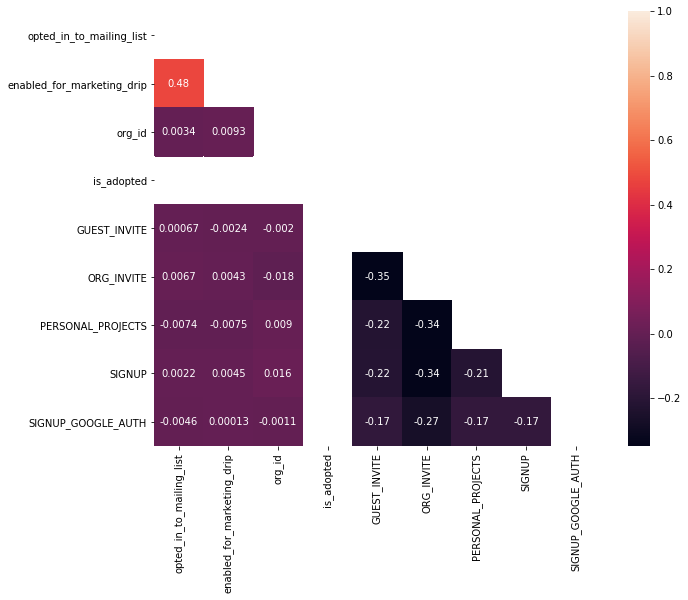

In [18]:
plt.figure(figsize=(10,8))
matrix = np.triu(users_df.corr())
sns.heatmap(users_df.corr(), annot=True, mask=matrix)

## Feature importance analysis (using ensamble - random forest)

Feature ranking:
1. feature 7 (0.00)
2. feature 6 (0.00)
3. feature 5 (0.00)
4. feature 4 (0.00)
5. feature 3 (0.00)
6. feature 2 (0.00)
7. feature 1 (0.00)
8. feature 0 (0.00)


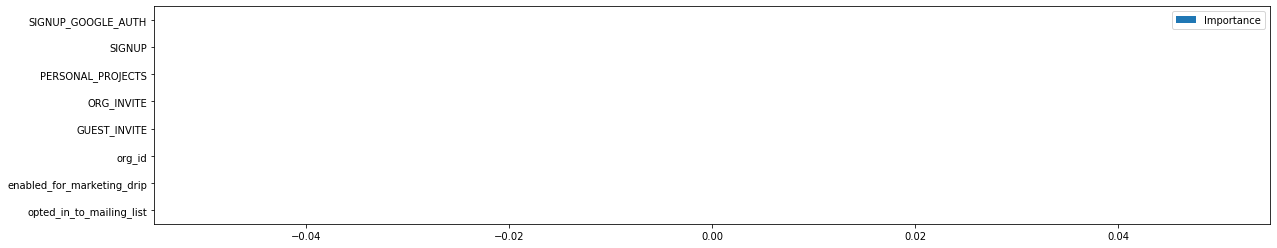

In [19]:
X = users_df.drop(['is_adopted','last_session_creation_time'], axis=1)
y = users_df['is_adopted']

from sklearn.ensemble import RandomForestClassifier

# Using Random Forest to gain an insight on Feature Importance
rfclf = RandomForestClassifier()
rfclf.fit(X, y)

importances = rfclf.feature_importances_

std = np.std([tree.feature_importances_ for tree in rfclf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%.2f)" % (f + 1, indices[f], importances[indices[f]]))

df_importances = pd.DataFrame(importances, index=X.columns, columns=["Importance"])
df_importances.sort_values(by='Importance', ascending=True).plot(kind='barh', figsize=(20,len(importances)/2));

In [20]:
## Above step wasnt sucessful, couldnt get any predictions

## Principal Component analysis

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#scale data
scaler = StandardScaler()
features = scaler.fit_transform(X)

#fit PCA
pca = PCA()
components = pca.fit_transform(X)

In [22]:
np.sum(pca.explained_variance_ratio_[0:8])

0.9999999999999999

In [23]:
df_comp = pd.DataFrame(pca.components_,columns=X.columns,index=['PC-1','PC-2','PC-3','PC-4','PC-5','PC-6','PC-7','PC-8'])
#absolute values of correlation with principal components
best_features = np.absolute(df_comp[np.absolute(df_comp) > 0.1])
best_features.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
PC-1,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
PC-2,NaN,NaN,NaN,0.272787,0.886234,0.256106,0.247910,0.109432
PC-3,0.828203,0.558802,NaN,NaN,NaN,NaN,NaN,NaN
PC-4,NaN,NaN,NaN,0.805201,NaN,0.516351,0.290628,NaN
PC-5,NaN,NaN,NaN,0.130382,NaN,0.632713,0.762878,NaN


In [24]:
#sum correlations to get a relative estimate of the feature importance
best_features.sum(axis=0).sort_values(ascending=False)

PERSONAL_PROJECTS             2.111889
SIGNUP                        2.016023
GUEST_INVITE                  1.900506
ORG_INVITE                    1.449156
SIGNUP_GOOGLE_AUTH            1.444174
enabled_for_marketing_drip    1.387755
opted_in_to_mailing_list      1.387444
org_id                        1.000000
dtype: float64

## Final Report

From the above analysis, <br>

Important feature is how user signed up (if you add the importances of the four signup features above). 
Among the ways they sign up, "PERSONAL_PROJECTS" and "SIGNUP"  are the two categories with highest user adoption rate.
Hence, Encouraging users to invite others, and offering incentives for people to work on their personal projects using the software might be effective.
I recommend that an effective way of growing adopted users might be encouraging existing users to log in and use the software after they had accounts for a while. <br>

Mailing list and marketing drip are not effective.<br>

The first 5 principal components account for most of the data variation in the dataset of adopted users, meaning that these variables are highly predictive of adopted users. 